In [298]:
import requests
import datetime
import pymysql
import json
from elasticsearch import Elasticsearch
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import progressbar
import redis
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def to_date(s):
    dt = datetime.datetime.fromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d-%H")
def utc_to_date(s):
    dt = datetime.datetime.utcfromtimestamp(s / 1e3)
    return dt.strftime("%Y-%m-%d-%H")

In [209]:
sql = "select `shop_id`, `shop_redpacket_id`,`user_id`,`price`,`status`,`source_type`,`order_id` FROM `shop_redpacket_record` WHERE `source_type`= 'vip_wake_up_giving'"

connect=pymysql.connect(
        host='rr-wz9cfug0i86qf0x9i.mysql.rds.aliyuncs.com',
        port=3306,
        user='bi_chenhao',
        password='Chenhao765123',
        database='shop-pro'
)
df_1 = pd.read_sql(sql,con = connect)
df_1['status'][0]

'2'

In [276]:
r = redis.Redis(host='47.112.147.187',port=6379,password='muxing2018',db=4,decode_responses=True)
result = r.get('hongbao_lv1')
result = json.loads(result)
result = {int(k):v for k ,v in result.items()}            #result字典集

group_0,group_1,group_2,group_3=[],[],[],[]

for item,value in result.items():
    if value == 0:                                  #对照组
        group_0.append(item)
    elif value == 1:                                #100-20
        group_1.append(item)
    elif value == 2:                                #3-3
        group_2.append(item)
    elif value == 3:                                #5-3
        group_3.append(item)

In [268]:
group_1[0]

272385

In [86]:
df_already=df_1[df_1['status']=='2']

In [87]:
df_already.head()

,shop_id,shop_redpacket_id,user_id,price,status,source_type,order_id
0,9997,0,155111,6000,2,vip_wake_up_giving,2161838
2,9997,0,155797,300,2,vip_wake_up_giving,2156361
14,9997,0,557156,300,2,vip_wake_up_giving,2162351
22,9997,0,688269,300,2,vip_wake_up_giving,2173141
32,9997,0,393400,300,2,vip_wake_up_giving,2159867


In [103]:
order_list=df_already['order_id'].tolist()

In [213]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'品类': {'terms': {'field': 'group_category_name'}}},
                                                       {'商家':{'terms':{'field':'shop_id'}}},
                                                       {'会员ID':{'terms':{'field':'user_id'}}},
                                                       {'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '1d',
                                                                                  'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [ {'terms': {'user_id': group_0}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df = json_normalize(res['aggregations']['my_buckets']['buckets'])

In [217]:
df['key.日期'] = df['key.日期'].apply(to_date)
df['key.日期'] = pd.to_datetime(df['key.日期'])
df.head()

,doc_count,key.会员ID,key.品类,key.商家,key.日期,折前GMV.value
0,2,486044,ktv,11033,2019-05-20 08:00:00,98.0
1,1,595640,ktv,11033,2019-05-11 08:00:00,98.0
2,1,428685,ktv,11205,2019-05-23 08:00:00,99.0
3,1,706102,ktv,11205,2019-05-22 08:00:00,99.0
4,1,270235,null,365,2019-05-16 08:00:00,8.0


In [ ]:
df['品类']

In [54]:
df['红包.value'].value_counts()

3.0     770
20.0     25
60.0      1
Name: 红包.value, dtype: int64

In [55]:
df_twenty=df[df['红包.value']==20]

In [69]:
df_twenty['品类'].value_counts()

粤菜/早茶      9
蛋糕/甜点      4
麻辣烫/串串香    3
衣物/皮具洗护    2
港式/茶餐厅     2
饮品店        1
客家菜        1
湘菜         1
东南亚菜       1
川菜         1
Name: 品类, dtype: int64

In [70]:
df_three=df[df['红包.value']==3]

In [71]:
df_three['品类'].value_counts()

蛋糕/甜点      553
饮品店         46
快餐          35
西餐          29
早餐档         25
下午茶         18
粤菜/早茶       12
麻辣烫/串串香      9
小吃           8
日本料理         7
null         6
网咖           3
港式/茶餐厅       3
甜品店          2
超市/便利店       2
小火锅          2
衣物/皮具洗护      2
酸菜鱼          2
音乐餐吧         2
海鲜           1
创意菜/特色菜      1
鱼火锅          1
川味/重庆火锅      1
Name: 品类, dtype: int64

In [336]:
begin = '2019-06-14 18:00:00'
end = '2019-06-17 10:00:00'
form = 'yyyy-MM-dd HH:mm:ss'

In [337]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '4h',
                                                                                  'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'gte': begin,
                                                     'lte': end,
                                                   'format': form}}},
                                {'terms': {'user_id':  group_0}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}
                       ]}}}
es0 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res0 = es0.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df0 = json_normalize(res0['aggregations']['my_buckets']['buckets'])

In [338]:
#df0.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df0.columns))
df0['key.日期'] = df0['key.日期'].apply(utc_to_date)
df0['key.日期'] = pd.to_datetime(df0['key.日期'])

In [339]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '4h',
                                                                                  'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'format': form,
                                                           'gte': begin,
                                                           'lte': end}}},
                                 {'terms': {'user_id': group_1}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es1 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res1 = es1.search(index='es_order_table', doc_type='order', body=dsl,
                    _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                    search_type='query_then_fetch')
df1 = json_normalize(res1['aggregations']['my_buckets']['buckets'])
#df1.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df1.columns))
df1['key.日期'] = df1['key.日期'].apply(utc_to_date)
df1['key.日期'] = pd.to_datetime(df1['key.日期'])
df1.head()

,doc_count,key.日期,折前GMV.value
0,29,2019-06-14 16:00:00,597.160001
1,30,2019-06-14 20:00:00,2167.519995
2,2,2019-06-15 00:00:00,56.000000
3,13,2019-06-15 04:00:00,208.100001
4,61,2019-06-15 08:00:00,1391.700000


In [340]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '4h',
                                                                                  'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [ {'range': {'paytime': {'format': form,
                                                           'gte': begin,
                                                           'lte': end}}},
                                 {'terms': {'user_id': group_2}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es2 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res2 = es2.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df2 = json_normalize(res2['aggregations']['my_buckets']['buckets'])
#df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df2.columns))
df2['key.日期'] = df2['key.日期'].apply(utc_to_date)
df2['key.日期'] = pd.to_datetime(df2['key.日期'])
df2.head()

,doc_count,key.日期,折前GMV.value
0,40,2019-06-14 16:00:00,1362.399998
1,49,2019-06-14 20:00:00,1798.400001
2,4,2019-06-15 00:00:00,797.000000
3,22,2019-06-15 04:00:00,296.899998
4,73,2019-06-15 08:00:00,1401.699993


In [341]:
dsl ={'aggs': {'my_buckets': {'aggregations': {'折前GMV': {'sum': {'field': 'skutotal_price'}}},
                             'composite': {'size': 9999999,
                                           'sources': [{'日期': {'date_histogram': {'field': 'paytime',
                                                                                  'interval': '4h',
                                                                                  'time_zone': '+00:00'}}}
                                                      ]}}},
     'query': {'bool': {'must': [{'range': {'paytime': {'format':form,
                                                           'gte': begin,
                                                           'lte': end}}},
                                 {'terms': {'user_id': group_3}},
                                 {'terms': {'order_status': ['done',
                                                             'fulfilled',
                                                             'confirmed']}}]
                       }}}
es3 = Elasticsearch(['http://172.18.198.27:9200/'], timeout=30)
res3 = es.search(index='es_order_table', doc_type='order', body=dsl,
                                _source=False, explain=False, track_scores=False, track_total_hits=False, size=0,
                                search_type='query_then_fetch')
df3 = json_normalize(res3['aggregations']['my_buckets']['buckets'])
#df.columns = map(lambda x: x.split('key.')[-1] if x.startswith('key.') else x, list(df3.columns))
df3['key.日期'] = df3['key.日期'].apply(utc_to_date)
df3['key.日期'] = pd.to_datetime(df3['key.日期'])
df3.head()

,doc_count,key.日期,折前GMV.value
0,33,2019-06-14 16:00:00,1462.699998
1,41,2019-06-14 20:00:00,1623.040002
2,1,2019-06-15 00:00:00,5.000000
3,21,2019-06-15 04:00:00,716.200002
4,63,2019-06-15 08:00:00,1220.399993


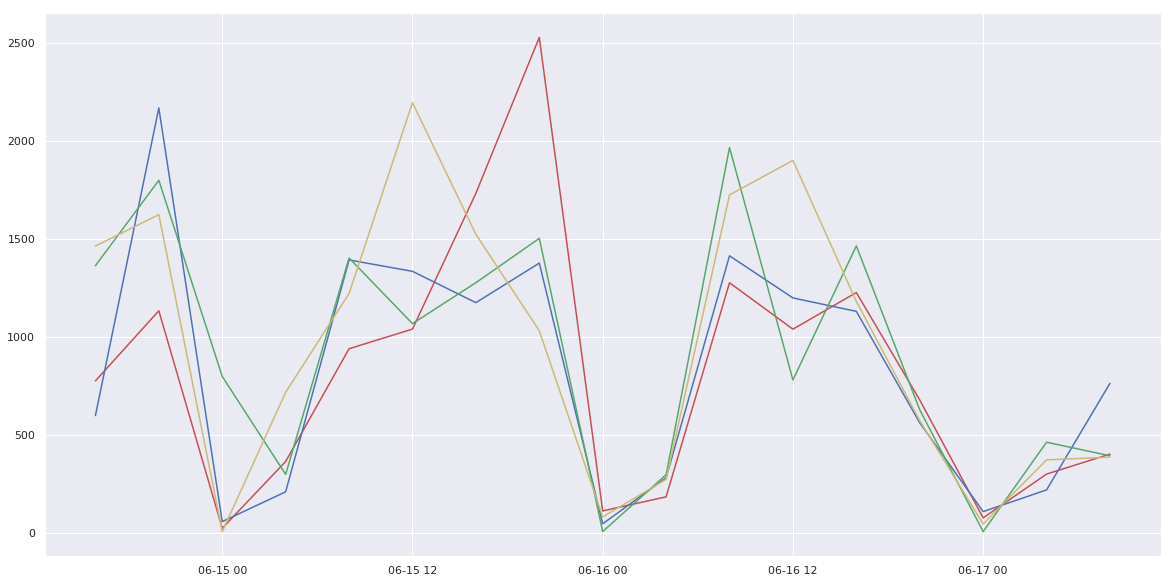

In [342]:
f,ax = plt.subplots(figsize = (20,10))
plt.plot(df0['key.日期'],df0['折前GMV.value'],'r-',       #对照
        df1['key.日期'],df1['折前GMV.value'],'b-',        #100-20
        df2['key.日期'],df2['折前GMV.value'],'g-',        #3-3
        df3['key.日期'],df3['折前GMV.value'],'y-'         #5-3
        )
